In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/decision-tree.csv")

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree:
    def __init__(self, min_samples_split=10, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [ ]:
acc_array = []
for i in range(10,100):
  depth = i

  tree = DecisionTree(max_depth=depth)
  tree.fit(X_train, y_train)

  # Make predictions on the test set
  predictions = tree.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, predictions)
  if(i%10 == 0):
    print(f"For depth {depth} accuracy is {accuracy}")

  acc_array.append(accuracy)

For depth 10 accuracy is 0.7597402597402597
For depth 20 accuracy is 0.7467532467532467
For depth 30 accuracy is 0.7337662337662337
For depth 40 accuracy is 0.7532467532467533
For depth 50 accuracy is 0.7467532467532467
For depth 60 accuracy is 0.7467532467532467
For depth 70 accuracy is 0.7402597402597403
For depth 80 accuracy is 0.7467532467532467
For depth 90 accuracy is 0.7337662337662337


Text(0, 0.5, 'Test Accuracy')

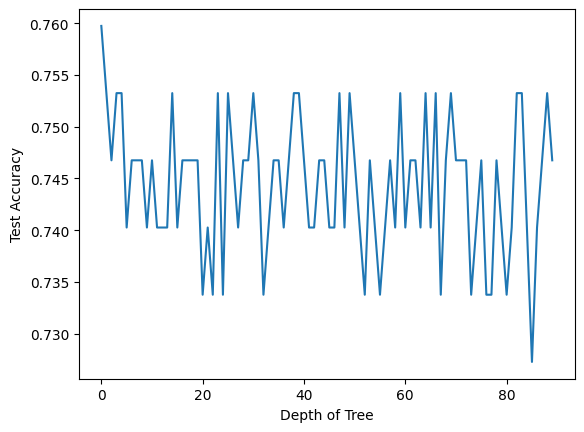

In [ ]:
import matplotlib.pyplot as plt

plt.plot(acc_array)
plt.xlabel("Depth of Tree")
plt.ylabel("Test Accuracy")

In [ ]:
macro_precision = precision_score(y_test, predictions, average='macro' )
print("Macro Precision:", macro_precision)

Macro Precision: 0.7252155172413793


In [ ]:
macro_recall = recall_score(y_test, predictions, average ='macro')
print("Macro Recall:", macro_recall)

Macro Recall: 0.7303030303030302


Reduced Error Pruning

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree_RP:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.pruned = False
        self.initial_accuracy = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)
        self.initial_accuracy = self._calculate_accuracy(X, y)
        self._reduced_error_pruning(self.root, X, y)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feat_idx in range(self.n_features):
            thresholds = np.unique(X[:, feat_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feat_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feat_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def _reduced_error_pruning(self, node, X, y):
        if node.is_leaf_node():
            return

        original_value = node.value
        node.value = self._most_common_label(y)
        pruned_accuracy = self._calculate_accuracy(X, y)

        if pruned_accuracy >= self.initial_accuracy:
            node.left = None
            node.right = None
        else:
            node.value = original_value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


    def print_tree(self, node=None, indent=""):
        if node is None:
            node = self.root

        if node.is_leaf_node():
            print(indent + "Leaf: Predicted Class =", node.value)
            return

        print(indent + f"Feature {node.feature} <= {node.threshold}")
        print(indent + "--> True:")
        self.print_tree(node.left, indent + "   ")
        print(indent + "--> False:")
        self.print_tree(node.right, indent + "   ")


In [ ]:
# Train a decision tree with reduced error pruning and information gain
clf_RP = DecisionTree_RP(max_depth=10)
clf_RP.fit(X_train, y_train)

# Calculate and print accuracy on the test set
predictions = clf_RP.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print("Accuracy after Reduced Error Pruning:", acc)

Accuracy after Reduced Error Pruning: 0.7402597402597403


In [ ]:
clf_RP.print_tree()

Feature 1 <= 127.0
--> True:
   Feature 7 <= 28.0
   --> True:
      Feature 5 <= 30.9
      --> True:
         Feature 6 <= 0.666
         --> True:
            Leaf: Predicted Class = 0
         --> False:
            Feature 6 <= 0.678
            --> True:
               Leaf: Predicted Class = 1
            --> False:
               Leaf: Predicted Class = 0
      --> False:
         Feature 2 <= 30.0
         --> True:
            Leaf: Predicted Class = 1
         --> False:
            Feature 6 <= 0.498
            --> True:
               Feature 3 <= 0.0
               --> True:
                  Feature 1 <= 106.0
                  --> True:
                     Leaf: Predicted Class = 0
                  --> False:
                     Feature 1 <= 121.0
                     --> True:
                        Leaf: Predicted Class = 1
                     --> False:
                        Leaf: Predicted Class = 0
               --> False:
                  Feature 5 <= 31

In [ ]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree_RP:
    def __init__(self, min_samples_split=10, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.pruned = False
        self.initial_accuracy = None

    def fit(self, X, y, X_val, y_val):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)
        self.initial_accuracy = self._calculate_accuracy(X_val, y_val)
        self._reduced_error_pruning(self.root, X, y, X_val, y_val)

    def _calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feat_idx in range(self.n_features):
            thresholds = np.unique(X[:, feat_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feat_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feat_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def _reduced_error_pruning(self, node, X, y, X_val, y_val):
      if node is None or node.is_leaf_node():
          return

      original_value = node.value
      node.value = self._most_common_label(y)
      pruned_accuracy = self._calculate_accuracy(X_val, y_val)

      if pruned_accuracy >= self.initial_accuracy:
          node.left = None
          node.right = None
      else:
          node.value = original_value

      self._reduced_error_pruning(node.left, X, y, X_val, y_val)
      self._reduced_error_pruning(node.right, X, y, X_val, y_val)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def print_tree(self, node=None, indent=""):
        if node is None:
            node = self.root

        if node.is_leaf_node():
            print(indent + "Leaf: Predicted Class =", node.value)
            return

        print(indent + f"Feature {node.feature} <= {node.threshold}")
        print(indent + "--> True:")
        self.print_tree(node.left, indent + "   ")
        print(indent + "--> False:")
        self.print_tree(node.right, indent + "   ")

    def print_tree(self, node=None, indent=""):
        if node is None:
            node = self.root

        if node.is_leaf_node():
            print(indent + "Leaf: Predicted Class =", node.value)
            return

        print(indent + f"Feature {node.feature} <= {node.threshold}")
        print(indent + "--> True:")
        self.print_tree(node.left, indent + "   ")
        print(indent + "--> False:")
        self.print_tree(node.right, indent + "   ")

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=1234)

# Train a decision tree with reduced error pruning using a validation set
clf = DecisionTree_RP(max_depth=10)
clf.fit(X_train, y_train, X_val, y_val)

# Prune the tree using the validation set
clf._reduced_error_pruning(clf.root, X_train, y_train, X_val, y_val)

# Calculate and print accuracy on the test set
predictions = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)
print("Accuracy on Test Set after Reduced Error Pruning:", acc)



Accuracy on Test Set after Reduced Error Pruning: 0.6162162162162163


In [ ]:
pip freeze > requirements.txt